# Overview

I have decided to try a few pretrained models using two/three different optimizers for each of them, subset of:<br>
{VGG16, MobileNet, ResNet50, ResNet152} x {Adagrad, sgd, adam} <br>
The intuition behind is that since our optimizers have different behaviour we might end up in different local minimas or different offsets of the same minima. Therefore ensembling those models might help us in achieving an improvement on unseen data.
<br><br>

Pretrained models requires image input shape of at least (32, 32, 3). <br>
Our images are of shape (28, 28, 1), therefore:

*   Image is stacked to get three channels
*   Padding is added to simulate (32, 32) images from our (28, 28) images

Intuitively this requires adjusting our already learned weights so that they know to "ignore padding".<br> Obviously weights need to adjust to the mere dataset as well.
<br> <br>

To my surprise data augmentation led to worse results.
<br><br>
All trained models are available to download:
[models](https://drive.google.com/drive/folders/1KwARsMo_-h4Xgie1ok-pbxAltDBavrZD?usp=sharing) <br><br>
Note:<br>
Some additional tunning, earlier stopping, grid-search etc. could lead to further improvement in the score thus there is still a lot of space for the improvement!<br>

# Tools

### Data preprocessing

In [0]:
def add_padding(data, desired_shape=(32, 32, 3)):
    import numpy as np
    data_padded = []
    for img in data:
        x = desired_shape[0] - img.shape[0]
        y = desired_shape[1] - img.shape[1]
        img = np.moveaxis(np.asarray([img, img, img]), 0, -1)
        padded_img = np.pad(img, ((x//2, y//2), (x//2, y//2), (0, 0)), mode='constant')
        data_padded.append(padded_img)
    return np.asarray(data_padded)

def get_padded_dataset():
    from tensorflow.keras import datasets
    fashion_mnist = datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    return (add_padding(train_images).astype('float32')/255.0, train_labels), (add_padding(test_images).astype('float32')/255.0, test_labels)

### Data Augmentation

Augmentation I have decided not to use:<br>

*   featurewise_std_normalization - not necessary in case of images since they are already in range [0:255] or [0:1]
*   samplewise_center - used featurewise_center
*   zoom_range - images are too small and it is too big a distortion
*   vertical_flip - didn't work







In [0]:
def get_data_generator():
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    data_generator = ImageDataGenerator(
                featurewise_center=True,
                rotation_range=10,
                shear_range=0.1,
                horizontal_flip=True)
                #samplewise_center=True,
                #featurewise_std_normalization=True,
                #zoom_range=0.15,
                #vertical_flip=True)
    data_generator.fit(train_images)
    return data_generator

### Predictions

In [0]:
def make_predictions(model, x):
    import numpy as np
    return np.argmax(model.predict(x), axis=1)

def save_predictions(predictions, filename):
    import pandas as pd
    df = pd.DataFrame(predictions, columns=['Class'])
    df.index.name = 'Id'
    df.to_csv(filename + '.csv')

### Training

Set of tools used for training models thus we can glibly train and compare different models.

In [0]:
def train_model(model, num_epochs=20, batch_size=32, data_generator=None):
    from tensorflow.keras.callbacks import ModelCheckpoint
    filepath = f'/content/gdrive/My Drive/Machine Learning/fashion-mnist/{model.name}.h5py'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', mode='max', verbose=1,
                                 save_best_only=True)

    if data_generator:
        model.fit_generator(generator=data_generator.flow(train_images, train_labels, batch_size, shuffle=True),
                    steps_per_epoch=train_images.shape[0] // batch_size,
                    validation_data = data_generator.flow(test_images, test_labels, batch_size),
                    validation_steps = test_images.shape[0] // batch_size,
                    epochs=num_epochs,
                    callbacks=[checkpoint])
    else:
        model.fit(x=train_images, y=train_labels,
              validation_data=(test_images, test_labels),
              batch_size=batch_size,
              epochs=num_epochs,
              callbacks=[checkpoint])

### Models management

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

def save_model(model, model_name):
    model.save(f'/content/gdrive/My Drive/Machine Learning/fashion-mnist/{model_name}.h5py')

def load_model(model_name):
    return model.load(f'/content/gdrive/My Drive/Machine Learning/fashion-mnist/{model_name}.h5py')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Dataset

In [0]:
from sklearn.model_selection import train_test_split
(train_images, train_labels), (unlabeled_images, _) = get_padded_dataset()
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.10)

## No augmentation
Glimpse into our dataset

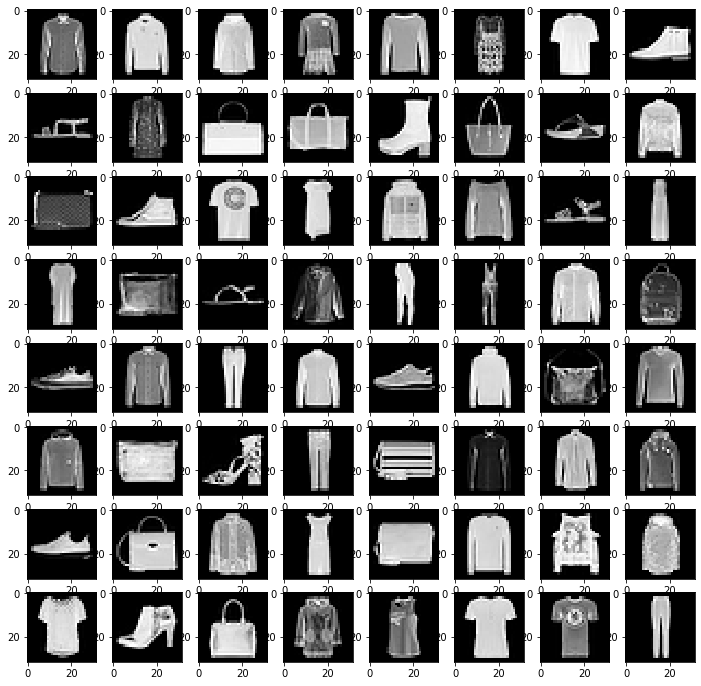

In [0]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(12, 12))
for i in range(1, 65):
    fig.add_subplot(8, 8, i)
    plt.imshow(train_images[i])
plt.show()

## Augmented dataset
Glimpse into our augmented dataset - looks reasonable!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

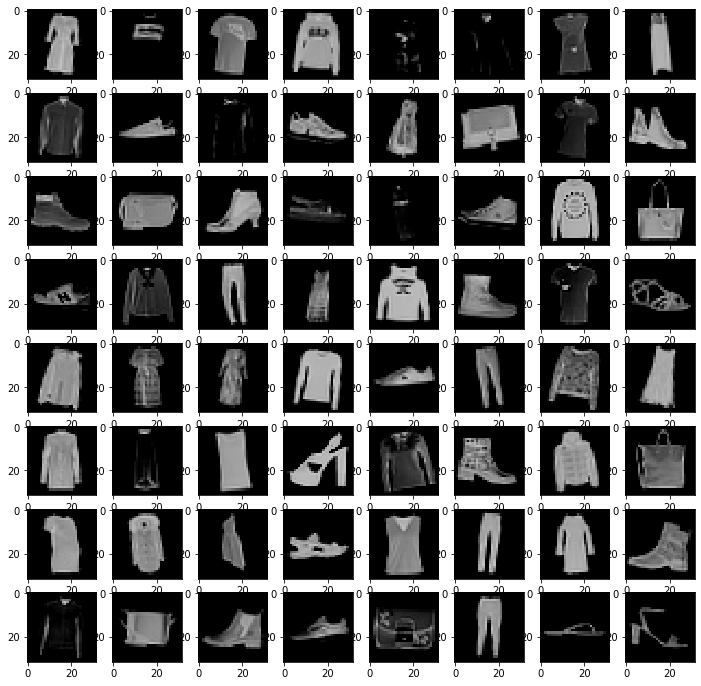

In [0]:
import matplotlib.pyplot as plt
import numpy as np

data_gen = get_data_generator()
fig=plt.figure(figsize=(12, 12))

for batch_x, batch_y in data_gen.flow(train_images, train_labels, batch_size=64):
    for i in range(1, 65):
        fig.add_subplot(8, 8, i)
        plt.imshow(batch_x[i - 1])
    break
del data_gen
plt.show()

# Training models

## VGG16
VGG16 with three different optimizers

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential

num_classes = 10
input_shape = (32, 32, 3)
optimizers = ['Adagrad', 'sgd', 'adam']

for optimizer in optimizers:
    model = Sequential(name=f'VGG16-{optimizer}')
    model.add(VGG16(include_top=False, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(units=num_classes, activation="softmax"))

    model.summary()
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    train_model(model)

Model: "VGG16-Adagrad"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
53984/54000 [============================>.] - ETA: 0s - loss: 0.3958 - acc: 0.8538
Epoch 00001: val_acc improved from -inf to 0.91483, saving model to /content/gdrive/My Drive/Ma

## VGG16 + Augmentation

VGG16 + Augmentation with three different optimizers

In [0]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential

num_classes = 10
input_shape = (32, 32, 3)
optimizers = ['Adagrad', 'sgd', 'adam']

for optimizer in optimizers:
    model = Sequential(name=f'VGG16-augmentation-{optimizer}')
    model.add(VGG16(include_top=False, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dense(units=num_classes, activation="softmax"))

    model.summary()
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    train_model(model, data_generator=get_data_generator())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step
Model: "VGG16-augmentation-Adagrad"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
Instructions for updating:
Call initializer instance with the dtype a

## MobileNet
MobileNet with three different optimizers

In [0]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential

num_classes = 10
input_shape = (32, 32, 3)
optimizers = ['Adagrad', 'sgd', 'adam']

for optimizer in optimizers:
    model = Sequential(name=f'MobileNet-{optimizer}')
    model.add(MobileNet(include_top=False, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(units=num_classes, activation="softmax"))

    model.summary()
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    train_model(model)

Model: "MobileNet-Adagrad"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1, 1, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 4,288,714
Trainable params: 4,266,826
Non-trainable params: 21,888
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/20
53984/54000 [============================>.] - ETA: 0s - loss: 0.6458 - acc: 0.7749
Epoch 00001: val_acc improved from -inf to 0.84233, saving model to /content/gdrive/My D

## MobileNet + Augmentation
MobileNet + Augmentation with two different optimizers

In [0]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential

num_classes = 10
input_shape = (32, 32, 3)
optimizers = ['sgd', 'adam']

for optimizer in optimizers:
    model = Sequential(name=f'MobileNet-augmentation-{optimizer}')
    model.add(MobileNet(include_top=False, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(units=num_classes, activation="softmax"))

    model.summary()
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    train_model(model, data_generator=get_data_generator())

17227776/17225924 [==============================] - 1s 0us/step
Model: "MobileNet-augmentation-sgd"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1, 1, 1024)        3228864   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_7 (Dense)              (None, 10)                10250     
Total params: 4,288,714
Trainable params: 4,266,826
Non-trainable params: 21,888
_________________________________________________________________
Epoch 1/20
 184/1687 [==>...........................] - ETA: 24s - loss: 0.3731 - acc: 0.8623
Epoch 00001: val_acc improved from -inf to 0.86197, saving model

## ResNet50
ResNet50 with three different optimizers - sgd suggested in paper

In [0]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential

num_classes = 10
input_shape = (32, 32, 3)
optimizers = ['Adagrad', 'sgd', 'adam']

for optimizer in optimizers:
    model = Sequential(name=f'ResNet50-{optimizer}')
    model.add(ResNet50(include_top=False, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(2048, activation="relu"))
    model.add(Dense(units=num_classes, activation="softmax"))

    model.summary()
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    train_model(model, num_epochs=10)

Model: "ResNet50-Adagrad"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_9 (Dense)              (None, 10)                20490     
Total params: 27,804,554
Trainable params: 27,751,434
Non-trainable params: 53,120
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53952/54000 [============================>.] - ETA: 0s - loss: 0.4139 - acc: 0.8573
Epoch 00001: val_acc improved from -inf to 0.89983, saving model to /content/gdrive/My 

## ResNet50 + Augmentation
ResNet50 + Augmentation with two different optimizers

In [0]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential

num_classes = 10
input_shape = (32, 32, 3)
optimizers = ['Adagrad', 'sgd']

for optimizer in optimizers:
    model = Sequential(name=f'ResNet50-augmentation-{optimizer}')
    model.add(ResNet50(include_top=False, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(2048, activation="relu"))
    model.add(Dense(units=num_classes, activation="softmax"))

    model.summary()
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    train_model(model, num_epochs=10, data_generator=get_data_generator())

94773248/94765736 [==============================] - 2s 0us/step
Model: "ResNet50-augmentation-Adagrad"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_11 (Dense)             (None, 10)                20490     
Total params: 27,804,554
Trainable params: 27,751,434
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/10
 185/1687 [==>...........................] - ETA: 38s - loss: 0.2990 - acc: 0.8926
Epoch 00001: val_acc improved from -inf to 0.89305, saving 

## ResNet152
ResNet152 with two different optimizers - sgd suggested in paper

In [0]:
''' VALID DO NOT RUN AGAIN '''

from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Sequential

num_classes = 10
input_shape = (32, 32, 3)
optimizers = ['Adagrad', 'sgd']

for optimizer in optimizers:
    model = Sequential(name=f'ResNet152-{optimizer}')
    model.add(ResNet152(include_top=False, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(2048, activation="relu"))
    model.add(Dense(units=num_classes, activation="softmax"))

    model.summary()
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    train_model(model, num_epochs=10)

234700800/234698864 [==============================] - 9s 0us/step
Model: "ResNet152-Adagrad"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 1, 1, 2048)        58370944  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_15 (Dense)             (None, 10)                20490     
Total params: 62,587,786
Trainable params: 62,436,362
Non-trainable params: 151,424
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53984/54000 [============================>.] - ETA: 0s - loss: 0.5026 - acc: 0.8292
Epoch 00001: val_a

# Ensembling

In [0]:
def load_models(models_names, path='/content/gdrive/My Drive/Machine Learning/fashion-mnist/'):
    from tensorflow.keras.models import load_model
    return [load_model(path + name + '.h5py') for name in models_names]

## No augmentation models
0.94600 score on kaggle public leaderboard

In [0]:
''' I have decided not to include models with validation score < 92% '''

models_names = []
to_skip = ['MobileNet-Adagrad', 'ResNet50-adam', 'ResNet152-Adagrad', 'ResNet152-adam']
for optimizer in ['Adagrad', 'sgd', 'adam']:
    for model_type in ['VGG16', 'MobileNet', 'ResNet50', 'ResNet152']:
        model_name = model_type + '-' + optimizer
        if model_name not in to_skip:
            models_names.append(model_name)

print("Chosen models:")
print(models_names)

Chosen models:
['VGG16-Adagrad', 'ResNet50-Adagrad', 'VGG16-sgd', 'MobileNet-sgd', 'ResNet50-sgd', 'ResNet152-sgd', 'VGG16-adam', 'MobileNet-adam']


In [0]:
from tensorflow.keras.layers import Input, average
from tensorflow.keras.models import Model

input_shape = (32, 32, 3)

inputs = Input(shape=input_shape)
outputs_all = []
models = load_models(models_names)
for model in models:
    outputs_all.append(model(inputs))
outputs = average(outputs_all)
ensemble_model = Model(inputs=inputs, outputs=outputs)

save_predictions(make_predictions(ensemble_model, unlabeled_images), 'ensemble_model')

In [0]:
save_model(ensemble_model, 'ensemble_model')

## Augmentation models
0.93066 score on kaggle public leaderboard

In [0]:
models_names = []
to_skip = ['MobileNet-augmentation-Adagrad', 'MobileNet-augmentation-sgd', 'MobileNet-augmentation-adam',
           'ResNet50-augmentation-Adagrad', 'ResNet50-augmentation-sgd', 'ResNet50-augmentation-adam']
for optimizer in ['Adagrad', 'sgd', 'adam']:
    for model_type in ['VGG16', 'MobileNet', 'ResNet50']:
        model_name = model_type + '-augmentation-' + optimizer
        if model_name not in to_skip:
            models_names.append(model_name)

print("Chosen models:")
print(models_names)

Chosen models:
['VGG16-augmentation-Adagrad', 'VGG16-augmentation-sgd', 'VGG16-augmentation-adam']


In [0]:
from tensorflow.keras.layers import Input, average
from tensorflow.keras.models import Model

input_shape = (32, 32, 3)

inputs = Input(shape=input_shape)
outputs_all = []
models = load_models(models_names)
for model in models:
    outputs_all.append(model(inputs))
outputs = average(outputs_all)
ensemble_augmentation_model = Model(inputs=inputs, outputs=outputs)

save_predictions(make_predictions(ensemble_augmentation_model, unlabeled_images), 'ensemble_augmentation_model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
save_model(ensemble_augmentation_model, 'ensemble_augmentation_model')